# **Deep Learning - Advanced Data Classification**








---



---


# Audio Classification using Deep Learning

## **Objective:**

1.   Develop a deep learning model that can classify audio recordings of firearm discharges, recognizing different types of firearms.


## **Dataset:**
1.   **Description:** A collection of audio recordings featuring various firearms being discharged in different orientations.


## **Requirements:**
1.  **Audio Data Preprocessing:** Implement techniques for processing and feature extraction from audio data.
2.   **Model Development:** Create a deep learning models ( LSTM, CNN ) that can classify the type of firearm and its orientation based on the audio recording.
1.   **Evaluation:** Evaluate your model using accuracy, precision, recall, and F1-score.
2.   **Report:** Write a comprehensive report documenting your approach, experiments, results, and any interesting findings or challenges.




















In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [ ]:

# Convert sounds to spectrograms
def read_data(folder_path):
    labels = []
    spectrograms = []

    for label in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, label)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file_path.endswith('.wav'):
                    y, sr = librosa.load(file_path)
                    S = librosa.stft(y)
                    S_mag = np.abs(S)
                    S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
                    spectrograms.append(S_dB)
                    labels.append(label)

    return spectrograms, labels

# Function to pad and/or trim a 2D array to appropriate shape
def pad2d(a, desired_size):
    rows, cols = a.shape
    padded_a = np.zeros((desired_size, desired_size))
    rows_to_copy = min(rows, desired_size)
    cols_to_copy = min(cols, desired_size)
    padded_a[:rows_to_copy, :cols_to_copy] = a[:rows_to_copy, :cols_to_copy]
    return padded_a


# Path to dataset
folder_path = '/content/drive/MyDrive/Colab Notebooks/DM & ML/Assignment 5/edge-collected-gunshot-audio'



# Read spectrograms and labels
spectrograms, labels = read_data(folder_path)



# Preprocess data
desired_spectrogram_size = 128
spectrograms = np.array([pad2d(s, desired_spectrogram_size) for s in spectrograms])
spectrograms = np.expand_dims(spectrograms, axis=-1)  # Add channel dimension
print(spectrograms.shape)
label_dict = {label: i for i, label in enumerate(set(labels))}
y = np.array([label_dict[label] for label in labels])
y = to_categorical(y)  # One-hot encoding



# Split data
X_train, X_test, y_train, y_test = train_test_split(spectrograms, y, test_size=0.2, random_state=42)



# Define input shape and number of classes
input_shape = X_train[0].shape
num_classes = y.shape[1]




(2148, 128, 128, 1)


In [ ]:
# Create CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model_cnn = model
    return model_cnn
# model_cnn.summary()

In [ ]:

# Create and compile the model
model_cnn = create_cnn_model(input_shape, num_classes)
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_cnn = model_cnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
54/54 [==============================] - 4s 26ms/step - loss: 2.6834 - accuracy: 0.4494 - val_loss: 1.9665 - val_accuracy: 0.4372
Epoch 2/100
54/54 [==============================] - 1s 21ms/step - loss: 1.2194 - accuracy: 0.5250 - val_loss: 1.9107 - val_accuracy: 0.4116
Epoch 3/100
54/54 [==============================] - 1s 22ms/step - loss: 1.0298 - accuracy: 0.5850 - val_loss: 1.1008 - val_accuracy: 0.5000
Epoch 4/100
54/54 [==============================] - 2s 30ms/step - loss: 0.9076 - accuracy: 0.6327 - val_loss: 1.6152 - val_accuracy: 0.4837
Epoch 5/100
54/54 [==============================] - 2s 32ms/step - loss: 0.7620 - accuracy: 0.6932 - val_loss: 0.9943 - val_accuracy: 0.6163
Epoch 6/100
54/54 [==============================] - 2s 30ms/step - loss: 0.5571 - accuracy: 0.7747 - val_loss: 0.7353 - val_accuracy: 0.7140
Epoch 7/100
54/54 [==============================] - 1s 26ms/step - loss: 0.5062 - accuracy: 0.7980 - val_loss: 1.0700 - val_accuracy: 0.6302
Epoch 

In [ ]:
#create LSTM model for comparison

def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model_lstm = model
    return model_lstm


In [ ]:
X_train_lstm = X_train.reshape(X_train.shape[0], desired_spectrogram_size, -1)
X_test_lstm = X_test.reshape(X_test.shape[0], desired_spectrogram_size, -1)

input_shape_lstm = X_train_lstm[0].shape

# Create and compile the LSTM model
model_lstm = create_lstm_model(input_shape_lstm, num_classes)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=100, validation_data=(X_test_lstm, y_test))


Epoch 1/100
54/54 [==============================] - 12s 60ms/step - loss: 0.2708 - accuracy: 0.9028 - val_loss: 1.6838 - val_accuracy: 0.5372
Epoch 2/100
54/54 [==============================] - 1s 26ms/step - loss: 0.1862 - accuracy: 0.9296 - val_loss: 1.1963 - val_accuracy: 0.7163
Epoch 3/100
54/54 [==============================] - 1s 27ms/step - loss: 0.1823 - accuracy: 0.9325 - val_loss: 1.6142 - val_accuracy: 0.6302
Epoch 4/100
54/54 [==============================] - 1s 27ms/step - loss: 0.2137 - accuracy: 0.9290 - val_loss: 1.2795 - val_accuracy: 0.6535
Epoch 5/100
54/54 [==============================] - 1s 26ms/step - loss: 0.2167 - accuracy: 0.9226 - val_loss: 1.0183 - val_accuracy: 0.7535
Epoch 6/100
54/54 [==============================] - 1s 26ms/step - loss: 0.1486 - accuracy: 0.9517 - val_loss: 2.0574 - val_accuracy: 0.6698
Epoch 7/100
54/54 [==============================] - 2s 29ms/step - loss: 0.1437 - accuracy: 0.9511 - val_loss: 0.8952 - val_accuracy: 0.7884
Epoch

In [ ]:


y_pred = model_cnn.predict(X_test)


y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


report = classification_report(y_true_labels, y_pred_labels, target_names=label_dict.keys())
print(report)



14/14 [==============================] - 0s 6ms/step
                             precision    recall  f1-score   support

     remington_870_12_gauge       0.92      0.76      0.83        78
       38s&ws_dot38_caliber       0.95      0.91      0.93       102
ruger_ar_556_dot223_caliber       0.82      0.97      0.89       120
       glock_17_9mm_caliber       0.92      0.90      0.91       130

                   accuracy                           0.90       430
                  macro avg       0.90      0.88      0.89       430
               weighted avg       0.90      0.90      0.89       430



In [ ]:


y_pred = model_lstm.predict(X_test)


y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


report = classification_report(y_true_labels, y_pred_labels, target_names=label_dict.keys())
print(report)



14/14 [==============================] - 1s 16ms/step
                             precision    recall  f1-score   support

     remington_870_12_gauge       0.69      0.76      0.72        78
       38s&ws_dot38_caliber       0.91      0.74      0.82       102
ruger_ar_556_dot223_caliber       0.83      0.77      0.80       120
       glock_17_9mm_caliber       0.76      0.88      0.82       130

                   accuracy                           0.79       430
                  macro avg       0.80      0.79      0.79       430
               weighted avg       0.80      0.79      0.79       430



14/14 [==============================] - 0s 9ms/step - loss: 0.6203 - accuracy: 0.8953


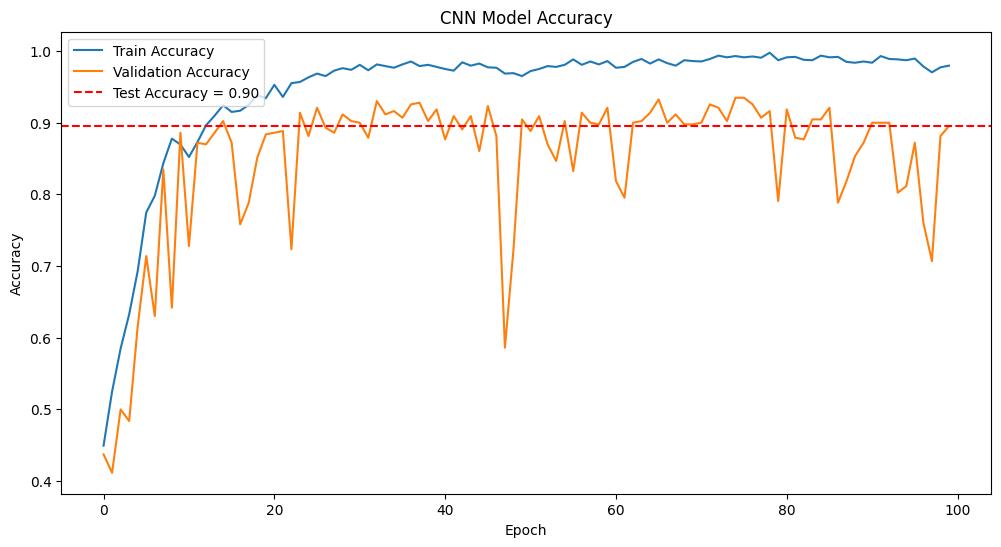

In [ ]:


test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test)

# Plotting CNN ccuracy
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy_cnn, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy_cnn:.2f}')
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


14/14 [==============================] - 0s 26ms/step - loss: 0.9137 - accuracy: 0.7930


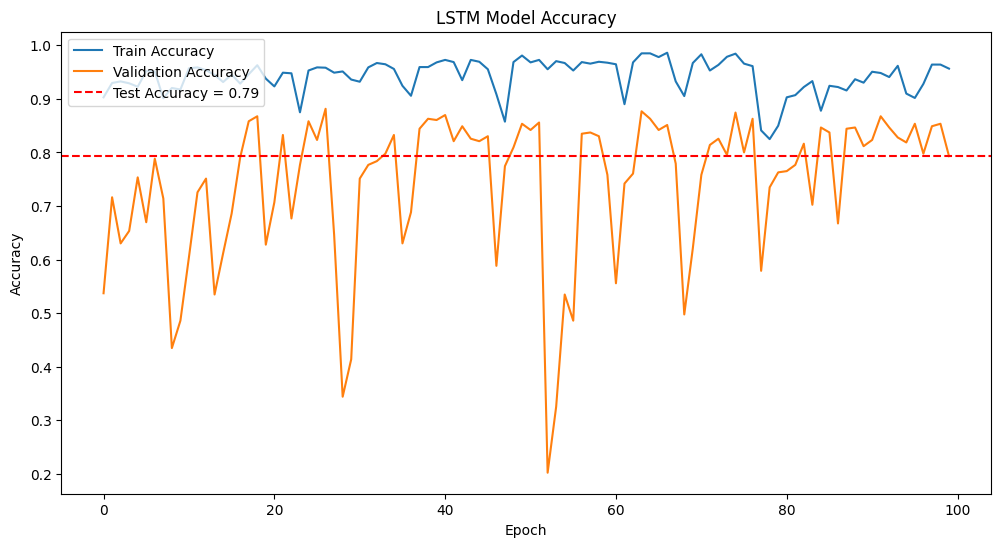

In [ ]:


test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test)

# Plotting LSTM Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy_lstm, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy_lstm:.2f}')
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()



#**3) Evaluation:**
## Evaluate your model using accuracy, precision, recall, and F1-score.


---

**CNN Model**
*   Accuracy: Across all classes, 90% accruacy was achived.
*   Precision: `38s&ws_dot38_caliber` was predicily precicly 95% of the time.
*   Recall: the model correctly identifies 97% of all actual `ruger_ar_556_dot223_caliber` uses
*   F1-Score: Is the weighted average of Precision and Recall. The besat blance was achived with `38s&ws_dot38_caliber` having a score of 93%.


**LSTM Model**
*   Accuracy: Across all classes, 80% accruacy was achived.
*   Precision: `38s&ws_dot38_caliber` was predicily precicly 91% of the time.
*   Recall: the model correctly identifies 88% of all actual `glock_17_9mm_caliber` uses
*   F1-Score: Is the weighted average of Precision and Recall. The besat blance was achived with `38s&ws_dot38_caliber` and  `glock_17_9mm_caliber` having a score of 82%.







# **4) Report:**
## Write a comprehensive report documenting your approach, experiments, results, and any interesting findings or challenges.

---

1. **Precision**:
   - Precision values are generally higher in the first model using CNN. With the lowest precision score being 8%2 for `ruger_ar_556_dot223_caliber`.
   - Precision values are lower using the second LSTM Model. With the lowest precision score being 69% for `remington_870_12_gauge`.

2. **Recall**:
   - The first CNN model shows higher recall values espeiclaly for `ruger_ar_556_dot223_caliber` at 97%.
   - The second LSTM model has lower recall values, with the highest being 88% for `glock_17_9mm_caliber`.

3. **F1-Score**:
   - The F1-scores are higher in the first Model across all classes. This indicates a more balanced performance between precision and recall.
   - In the second Model, the F1-scores are lower, suggesting lower overall accuracy and balance between precision and recall.

4. **Overall Accuracy**:
   - The model's overall accuracy is higher using the CNN model with an accuracy score of 90% compared to the LSTM Model at 79%.


5. **Macro and Weighted Averages**:
   - Both macro and weighted averages for precision, recall, and F1-score are higher in the CNN model compared to the LSTM Model.


